In [1]:
import pandas as pd
import torch as th
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [2]:
def augment(dataframe, threshold):

    df = pd.read_pickle(dataframe)
    esm_vectors = df["esm2"].values.tolist()
    esm_vectors = th.stack(esm_vectors)
    eye_matrix = th.eye(esm_vectors.shape[0])
    similarity_matrix = th.matmul(esm_vectors, esm_vectors.T)
    similarity_matrix = th.softmax(similarity_matrix, dim=1)
    similarity_matrix = similarity_matrix - eye_matrix

    augmented_annotations = list()
    
    for i, row in tqdm(enumerate(df.itertuples()), total=len(df)):
        most_similar = th.argmax(similarity_matrix[i, :]).item()
        if similarity_matrix[i, most_similar] > threshold:
            other_annots = df.iloc[most_similar].prop_annotations
            other_annots = set(other_annots)
            augmented_annots = set(row.prop_annotations) | other_annots
        else:
            augmented_annots = set(row.prop_annotations)

        augmented_annotations.append(list(augmented_annots))

    df["aug_prop_annotations"] = augmented_annotations
        
    return df

In [8]:
def get_similarity_matrix(df):
    esm_vectors = df["esm2"].values.tolist()
    esm_vectors = th.stack(esm_vectors).to("cuda")
    norms = th.norm(esm_vectors, p=2, dim=1, keepdim=True)
    esm_vectors = esm_vectors/norms
    similarity_matrix = th.matmul(esm_vectors, esm_vectors.T)
    
    #mask = similarity_matrix < 0.6
    #similarity_matrix[mask] = float('-inf')
    
    mask = th.eye(similarity_matrix.size(0)).bool()
    similarity_matrix[mask] = 0 #float('-inf')

#    similarity_matrix = th.sigmoid(similarity_matrix)
 #   mask = (similarity_matrix > 0.675).float()
 #   similarity_matrix = similarity_matrix * mask
    #similarity_matrix = similarity_matrix - th.max(similarity_matrix)
    #similarity_matrix = th.softmax(similarity_matrix, dim=0)
    return similarity_matrix

In [9]:
def show_histogram(tensor):
    flat_tensor = tensor.flatten()
    threshold = 0  # This means we consider values within -0.05 to 0.05 as very close to 0

    # Create a mask
    mask = th.abs(flat_tensor) >  threshold

# Filter the tensor
    filtered_tensor = flat_tensor[mask].cpu().numpy()
    # Create the histogram
    plt.hist(filtered_tensor, bins=100)  # Adjust the number of bins as needed
    plt.title('Distribution of Tensor Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

In [5]:
df = pd.read_pickle("data-sim/mf/train_data.pkl")

In [10]:
sim_matrix = get_similarity_matrix(df)
#nan_rows = th.isnan(sim_matrix).any(dim=1)
#nan_rows
#sim_matrix[nan_rows]

In [11]:
print(sim_matrix.min(), sim_matrix.max())

tensor(0., device='cuda:0') tensor(1.0000, device='cuda:0')


In [26]:
lt_zero = (sim_matrix < 0).float().sum()
lt_zero/(sim_matrix.shape[0] * sim_matrix.shape[1])

tensor(0., device='cuda:0')

In [14]:
import gc
#del sim_matrix
gc.collect()

8023

In [18]:
sim_matrix.max()

tensor(1.0000, device='cuda:0')

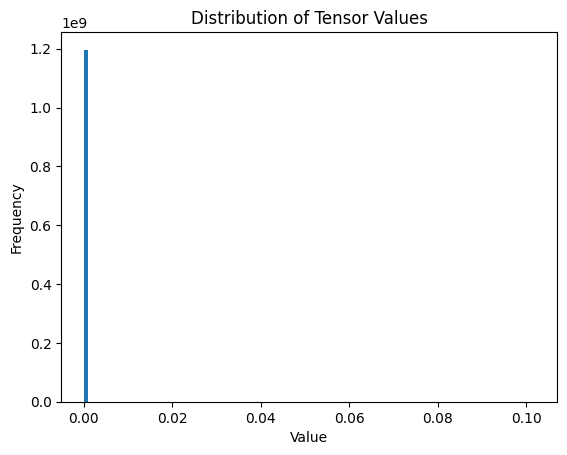

In [11]:
show_histogram(sim_matrix)

In [11]:
th.sum(sim_matrix[:, 1])

tensor(1.0000, device='cuda:0')

In [13]:
terms_df = pd.read_pickle("data-sim/mf/terms.pkl")
terms = terms_df['gos'].values.flatten()
terms_dict = {v: i for i, v in enumerate(terms)}

labels = th.zeros((len(df), len(terms_dict)), dtype=th.float32)

for i, row in enumerate(df.itertuples()):
    if not hasattr(row, 'prop_annotations'):
        continue
    for go_id in row.prop_annotations:
        if go_id in terms_dict:
            g_id = terms_dict[go_id]
            labels[i, g_id] = 1


In [14]:
labels.shape

torch.Size([39432, 7114])

In [15]:
sim_matrix.shape

torch.Size([39432, 39432])

In [15]:
per_class_annots = th.sum(labels, dim=0)

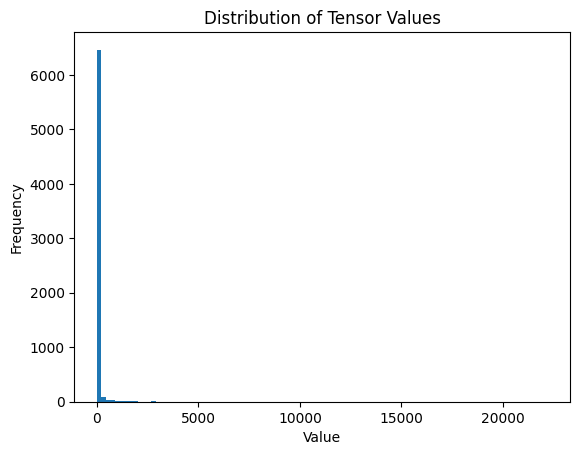

In [16]:
show_histogram(per_class_annots)

In [23]:
weighted_labels = th.zeros(labels.shape)
labels = labels.cuda()
pos_labels_den = (labels == 1).float().sum(dim = 0)
pos_labels_den = th.where(pos_labels_den == 0, th.ones_like(pos_labels_den), pos_labels_den)

for i, prot_annots in tqdm(enumerate(labels), total = len(labels)):
    prot_similarities = sim_matrix[i].unsqueeze(1).cuda()
    w_labels = prot_similarities * labels
    agg_w_labels = th.max(w_labels, dim = 0).values #/ pos_labels_den
    #print(agg_w_labels.shape)
    pos_mask = labels[i] == 1
    neg_mask = labels[i] != 1
    agg_w_labels = neg_mask * agg_w_labels + pos_mask 
    weighted_labels[i] = agg_w_labels

100%|██████████| 39432/39432 [02:50<00:00, 230.96it/s]


In [24]:
print(weighted_labels.min(), weighted_labels.max())

tensor(0.) tensor(1.0000)


In [25]:
weighted_labels

tensor([[0.5859, 0.0000, 0.6003,  ..., 1.0000, 0.8263, 1.0000],
        [0.5422, 0.0000, 0.6167,  ..., 0.7247, 1.0000, 0.7247],
        [0.6081, 0.0000, 0.6467,  ..., 0.7138, 0.8100, 0.7227],
        ...,
        [0.5203, 0.0000, 0.5536,  ..., 0.8707, 0.8520, 0.8707],
        [0.4980, 0.0000, 0.4717,  ..., 1.0000, 0.8344, 1.0000],
        [0.5849, 0.0000, 0.6050,  ..., 0.7953, 1.0000, 0.8070]])

In [28]:
mask = (weighted_labels > 0.9).float()
mask.sum()
#masked_w_labels = weighted_labels * mask

tensor(847217.)

In [21]:
per_class_w_annots = th.sum(masked_w_labels, dim=0)

In [22]:
per_class_w_annots

tensor([2.0000e+00, 0.0000e+00, 2.0000e+00,  ..., 1.2462e+04, 1.7447e+04,
        2.2210e+04])

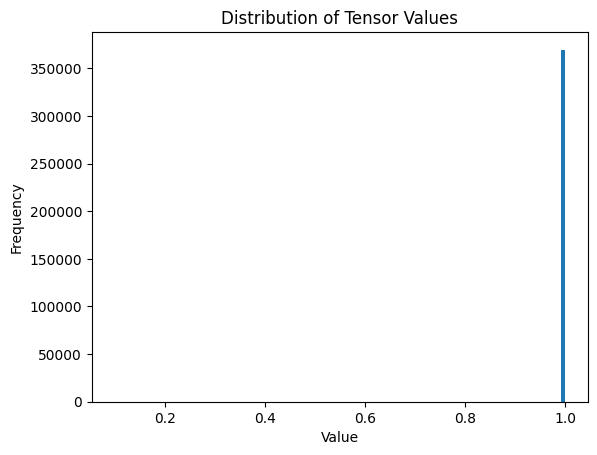

In [25]:
show_histogram(masked_w_labels)

In [29]:
w_labels_disk = pd.read_pickle("data-sim/mf/train_weighted_labels.pkl")
print(w_labels_disk.min(), w_labels_disk.max())

tensor(nan) tensor(nan)
